In [1]:
import gym, gym_futbol_v1
%matplotlib inline
from gym_futbol_v1.envs import Side
from utils import notebook_render_simple, notebook_render_mlp, notebook_render_lstm
from training import ppo2_mlp_policy_train, ppo2_mlp_lstm_policy_train
from stable_baselines import PPO2

Loading chipmunk for Darwin (64bit) [/Users/jim/Library/Python/3.7/lib/python/site-packages/pymunk/libchipmunk.dylib]
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



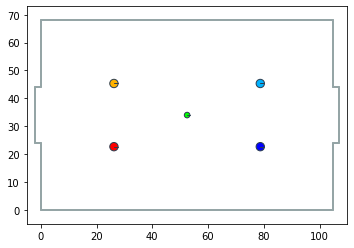

[[52.5        34.          0.          0.        ]
 [26.25       22.66666667  0.          0.        ]
 [26.25       45.33333333  0.          0.        ]
 [78.75       22.66666667  0.          0.        ]
 [78.75       45.33333333  0.          0.        ]]


In [2]:
env = gym.make("futbol-v1")
env.render()
print(env.reset().reshape((-1,4)))

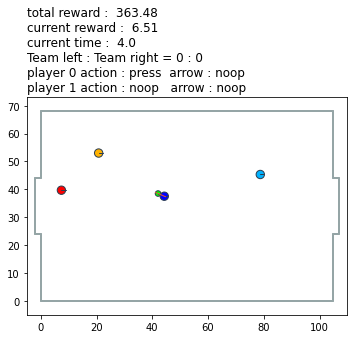

In [3]:
total_reward = notebook_render_simple(env, length=40, random=False, action=[0,3,0,0], side=Side.right)

In [4]:
model, save_dir = ppo2_mlp_policy_train(time_step=10**4)

--------------------------------------
| approxkl           | 0.0004084398  |
| clipfrac           | 0.0           |
| ep_len_mean        | 300           |
| ep_reward_mean     | 180           |
| explained_variance | 0.000474      |
| fps                | 1174          |
| n_updates          | 1             |
| policy_entropy     | 6.437246      |
| policy_loss        | -0.0036003604 |
| serial_timesteps   | 128           |
| time_elapsed       | 1.29e-05      |
| total_timesteps    | 1024          |
| value_loss         | 4262.2456     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00034331254 |
| clipfrac           | 0.0           |
| ep_len_mean        | 300           |
| ep_reward_mean     | 600           |
| explained_variance | -0.000727     |
| fps                | 2129          |
| n_updates          | 2             |
| policy_entropy     | 6.4347954     |
| policy_loss        | -0.0011820807 |
| serial_timesteps   | 25

In [5]:
best_model = PPO2.load(save_dir + "/best_model")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


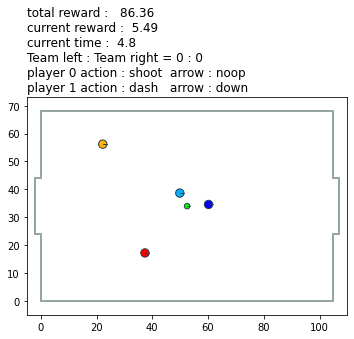

In [ ]:
total_reward = notebook_render_mlp('futbol-v1', best_model)

In [7]:
model, save_dir = ppo2_mlp_lstm_policy_train(time_step=10**4)

--------------------------------------
| approxkl           | 0.0013559756  |
| clipfrac           | 0.0026855469  |
| ep_len_mean        | 300           |
| ep_reward_mean     | 2.14e+03      |
| explained_variance | -7.36e-05     |
| fps                | 122           |
| n_updates          | 1             |
| policy_entropy     | 6.4276805     |
| policy_loss        | -0.0031477578 |
| serial_timesteps   | 128           |
| time_elapsed       | 1.53e-05      |
| total_timesteps    | 1024          |
| value_loss         | 17416.3       |
--------------------------------------
--------------------------------------
| approxkl           | 0.00050659373 |
| clipfrac           | 0.0           |
| ep_len_mean        | 300           |
| ep_reward_mean     | 1.16e+03      |
| explained_variance | -8.18e-05     |
| fps                | 268           |
| n_updates          | 2             |
| policy_entropy     | 6.4278665     |
| policy_loss        | 0.0008017018  |
| serial_timesteps   | 25

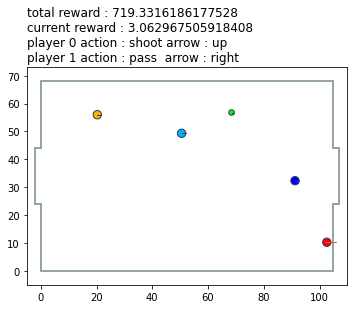

In [8]:
total_reward = notebook_render_lstm('futbol-v1', model)